In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import autograd.numpy as np
from autograd import grad

# Numerical/scientific computing packages.
import scipy
import copy
import seaborn as sns
import csv

# Machine learning package.
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error

# Useful for saving our models.
import pickle

# Plotting packages.
import matplotlib
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

print("Imported all!")

Imported all!


### QUESTION 1: Using multiple linear regression: What is the best predictor of total annual compensation, how much variance is explained by this predictor vs. the full multiple regression model?

In [54]:
file_path = 'techSalaries2017.csv'

df = pd.read_csv(file_path)
print("Size before dropping: ", df.size)
print(df.isnull().sum())
for i, column_name in enumerate(df.columns.values.tolist()):
    print("index:", str(i) + ";", "spec num:", str(i+1) + ";", "df['{}']".format(column_name))

Size before dropping:  1691334
company                        5
title                          0
location                       0
totalyearlycompensation        0
basesalary                     0
stockgrantvalue                0
bonus                          0
yearsofexperience              0
yearsatcompany                 0
gender                     19540
Masters_Degree                 0
Bachelors_Degree               0
Doctorate_Degree               0
Highschool                     0
Some_College                   0
Race_Asian                     0
Race_White                     0
Race_Two_Or_More               0
Race_Black                     0
Race_Hispanic                  0
Race                       40215
Education                  32272
Age                            0
Height                         0
Zodiac                         0
SAT                            0
GPA                            0
dtype: int64
index: 0; spec num: 1; df['company']
index: 1; spec num: 2; df['t

In [55]:
# drop columns we are not using for the predictions
columns_to_drop = ['company', 'title', 'location', 'Race_Two_Or_More', 'Masters_Degree', 'basesalary', 'stockgrantvalue', 'bonus']

for column in columns_to_drop:
    df = df.drop(column, axis=1)
    print("\nRemoving '{}' column from the prediction data".format(column))


def return_shape(df):
    return "Rows: " + str(df.shape[0]) + "; Columns: " + str(df.shape[1])

print(return_shape(df))
# let's drop all the columns that contain incomplete information about person's race or education cause we can't meaningfully use them for our model
df = df.dropna()
print(return_shape(df))
print("-----------------------------------")
df.isnull().sum()


Removing 'company' column from the prediction data

Removing 'title' column from the prediction data

Removing 'location' column from the prediction data

Removing 'Race_Two_Or_More' column from the prediction data

Removing 'Masters_Degree' column from the prediction data

Removing 'basesalary' column from the prediction data

Removing 'stockgrantvalue' column from the prediction data

Removing 'bonus' column from the prediction data
Rows: 62642; Columns: 19
Rows: 21591; Columns: 19
-----------------------------------


totalyearlycompensation    0
yearsofexperience          0
yearsatcompany             0
gender                     0
Bachelors_Degree           0
Doctorate_Degree           0
Highschool                 0
Some_College               0
Race_Asian                 0
Race_White                 0
Race_Black                 0
Race_Hispanic              0
Race                       0
Education                  0
Age                        0
Height                     0
Zodiac                     0
SAT                        0
GPA                        0
dtype: int64

In [56]:
df.head()

,totalyearlycompensation,yearsofexperience,yearsatcompany,gender,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Black,Race_Hispanic,Race,Education,Age,Height,Zodiac,SAT,GPA
15710,400000,5.0,5.0,Male,0,1,0,0,1,0,0,0,Asian,PhD,45,68.891,9,1166,3.04
23532,136000,3.0,2.0,Male,1,0,0,0,0,0,0,0,Two Or More,Bachelor's Degree,24,61.454,12,1175,3.07
23533,337000,6.0,6.0,Male,1,0,0,0,1,0,0,0,Asian,Bachelor's Degree,25,65.455,1,1268,3.34
23534,222000,4.0,4.0,Male,0,0,0,0,1,0,0,0,Asian,Master's Degree,32,73.769,8,1070,2.75
23535,187000,5.0,0.0,Male,1,0,0,0,0,1,0,0,White,Bachelor's Degree,29,68.710,2,1187,3.23


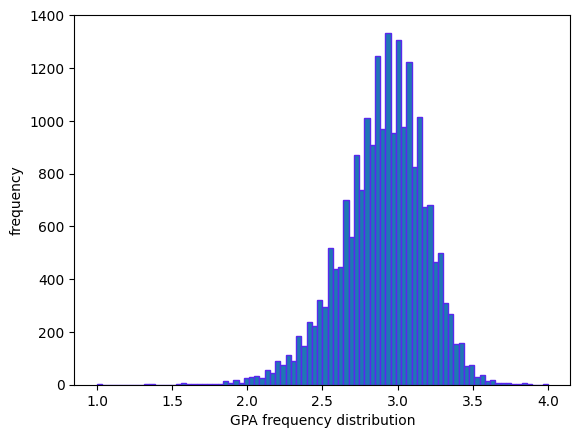

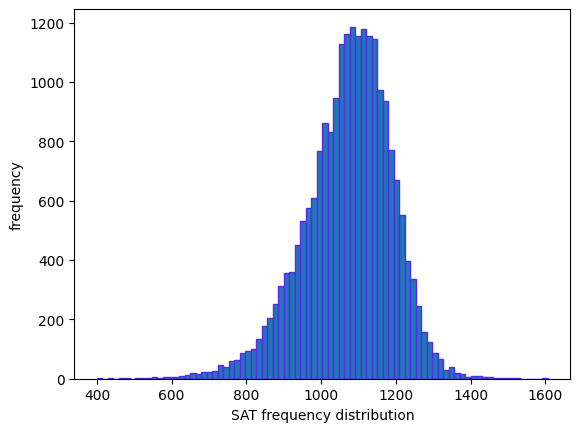

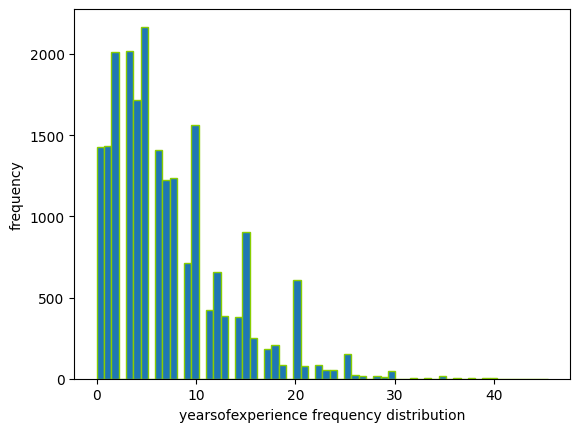

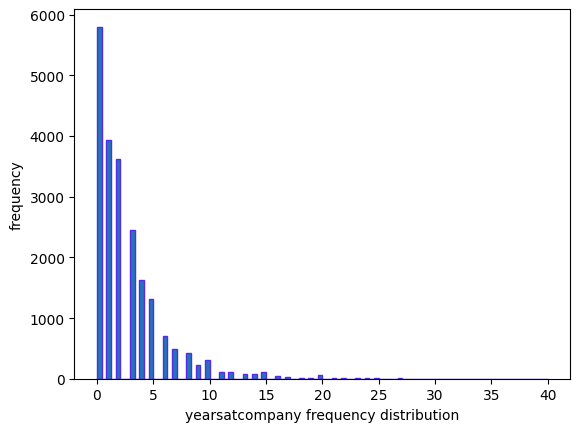

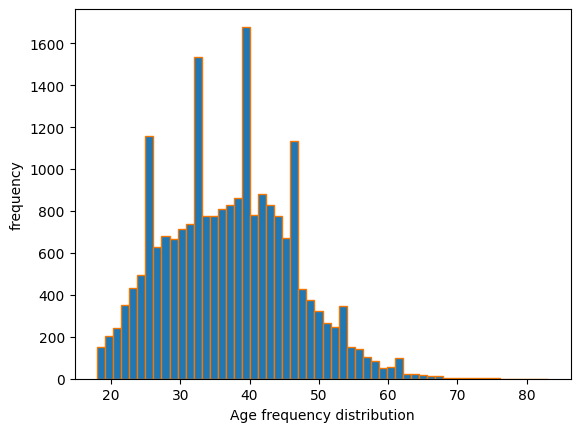

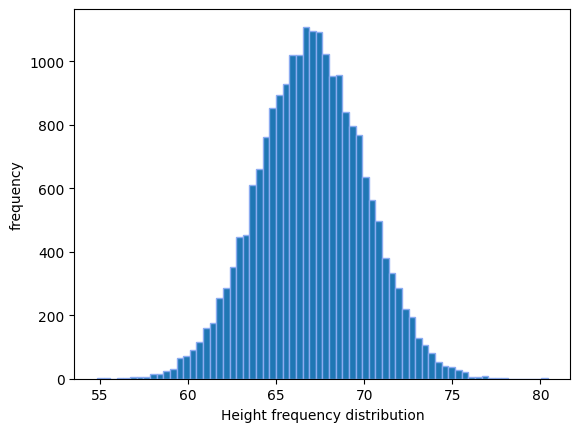

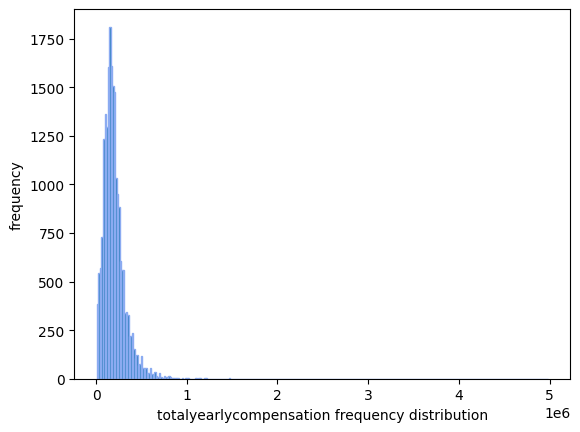

In [40]:
import random

def scatter_plot(ax, predictor, outcome, title):
    ax.scatter(predictor, outcome, s=7, alpha=0.1, color="orange")
    ax.set_title(f"{title} vs annual compensation")
    ax.set_xlabel(title)
    ax.set_ylabel("total annual compensation")


def plot_freq_dist(predictor, dataframe, color: str = "red", title = "N/A"):
    """
    data: 1d dataframe to plot on the graph
    """
    data = dataframe[predictor]
    data_size = data.shape[0]
    # Let's use the Scott's rule for choosing the right bin width
    w = 3.49 * np.std(data)/data_size**(1./3)

    # define number of bins with accordance to the appropriate size 
    bins = np.arange(data.min().item(), data.max().item() + w, w, dtype=float)

    plt.hist(data, edgecolor=color, bins=bins) 
    plt.xlabel("{} frequency distribution".format(title))  # Set x-axis label
    plt.ylabel("frequency")     # Set y-axis label
    plt.show()  # Show the plot

# List of color codes
color_codes = ['#f57600', '#8babf1', '#89ce00', '#e6308a', '#5928ed']

# We want to plot these values to identify what are the most useful predictors
predictors_list_and_outcome = ['GPA', 'SAT', 'yearsofexperience', 'yearsatcompany', 'Age', 'Height', 'totalyearlycompensation']

for predictor in predictors_list_and_outcome:
    plot_freq_dist(predictor, df, color = random.choice(color_codes), title = predictor)

In [57]:
columns_to_drop_p2 = ['Race', 'Education', 'Zodiac']
for column in columns_to_drop_p2:
    df = df.drop(column, axis=1)
    print("\nRemoving '{}' column from the prediction data".format(column))

df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0})
df = df[df['gender'] != 'Other']

print(return_shape(df))
df.head()


Removing 'Race' column from the prediction data

Removing 'Education' column from the prediction data

Removing 'Zodiac' column from the prediction data
Rows: 21485; Columns: 16


,totalyearlycompensation,yearsofexperience,yearsatcompany,gender,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Black,Race_Hispanic,Age,Height,SAT,GPA
15710,400000,5.0,5.0,1,0,1,0,0,1,0,0,0,45,68.891,1166,3.04
23532,136000,3.0,2.0,1,1,0,0,0,0,0,0,0,24,61.454,1175,3.07
23533,337000,6.0,6.0,1,1,0,0,0,1,0,0,0,25,65.455,1268,3.34
23534,222000,4.0,4.0,1,0,0,0,0,1,0,0,0,32,73.769,1070,2.75
23535,187000,5.0,0.0,1,1,0,0,0,0,1,0,0,29,68.710,1187,3.23


In [58]:
df.reset_index(drop=True, inplace=True)
df.head()

,totalyearlycompensation,yearsofexperience,yearsatcompany,gender,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Black,Race_Hispanic,Age,Height,SAT,GPA
0,400000,5.0,5.0,1,0,1,0,0,1,0,0,0,45,68.891,1166,3.04
1,136000,3.0,2.0,1,1,0,0,0,0,0,0,0,24,61.454,1175,3.07
2,337000,6.0,6.0,1,1,0,0,0,1,0,0,0,25,65.455,1268,3.34
3,222000,4.0,4.0,1,0,0,0,0,1,0,0,0,32,73.769,1070,2.75
4,187000,5.0,0.0,1,1,0,0,0,0,1,0,0,29,68.710,1187,3.23


In [59]:
columns_to_standardize = ['yearsofexperience', 'yearsatcompany', 'Age', 'SAT', 'GPA', 'Height']

from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Standardize selected columns
scaler = StandardScaler()
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

df.reset_index(drop=True, inplace=True)
print(return_shape(df))
df.head()

Rows: 21485; Columns: 16


,totalyearlycompensation,yearsofexperience,yearsatcompany,gender,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Black,Race_Hispanic,Age,Height,SAT,GPA
0,400000,-0.363185,0.689186,1,0,1,0,0,1,0,0,0,0.844970,0.631866,0.799149,0.493068
1,136000,-0.705146,-0.212187,1,1,0,0,0,0,0,0,0,-1.419666,-1.845582,0.875807,0.600828
2,337000,-0.192205,0.989643,1,1,0,0,0,1,0,0,0,-1.311826,-0.512751,1.667945,1.570668
3,222000,-0.534166,0.388728,1,0,0,0,0,1,0,0,0,-0.556947,2.256848,-0.018542,-0.548612
4,187000,-0.363185,-0.813102,1,1,0,0,0,0,1,0,0,-0.880467,0.571570,0.978018,1.175548


In [9]:
def multiple_linear_regression(predictors, outcome):
    """
    performing multiple linear regression
    """
    X = predictors
    y = outcome

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
        
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Generate predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Return relevant statistics
    return {
        "coefficients": model.coef_,
        "intercept": model.intercept_,
        "r2_score": r2,
        "rmse": rmse
    }


def output_multiple_regression_results(results):
    """
    results = multiple_linear_regression(new_predictors_df, Y)
    """
    print("\nSTARTING A NEW REPORT!!!")
    print("--------------------------------------------")
    print("Intercept: ", results["intercept"])
    print("--------------------------------------------")
    for i, ii in enumerate(results['coefficients']):
        print("Beta {}: ".format(i+1), ii)
    print("--------------------------------------------")
    print("R^2 Score: ", results["r2_score"])
    print("--------------------------------------------")
    print("RMSE: ", results["rmse"])
    print("--------------------------------------------")
    print("END OF THE REPORT\n")


multiple_regression_model = multiple_linear_regression(df.iloc[:, 1:], df.iloc[:, 0])
output_multiple_regression_results(multiple_regression_model)


STARTING A NEW REPORT!!!
--------------------------------------------
Intercept:  214308.9113687285
--------------------------------------------
Beta 1:  51993.22381560838
Beta 2:  -8197.668545966178
Beta 3:  4405.9319902769075
Beta 4:  -21122.598756547573
Beta 5:  71680.77506825485
Beta 6:  -35247.90954214685
Beta 7:  -22355.57122151503
Beta 8:  -13307.754264052413
Beta 9:  -9938.482797641394
Beta 10:  -21029.621346081833
Beta 11:  -15394.766326731124
Beta 12:  -241.51898172997434
Beta 13:  -1043.4917435612058
Beta 14:  33155.596609212196
Beta 15:  2622.436520652768
--------------------------------------------
R^2 Score:  0.23412388017585994
--------------------------------------------
RMSE:  125432.03516722495
--------------------------------------------
END OF THE REPORT



In [10]:
# note that this is a single predictor (but since it is categorical it is decomposed into multiple columns)
education_predictor = multiple_linear_regression(df.iloc[:, 4:8],  df.iloc[:, 0])
output_multiple_regression_results(education_predictor)


STARTING A NEW REPORT!!!
--------------------------------------------
Intercept:  212052.08621165715
--------------------------------------------
Beta 1:  -34586.58483170914
Beta 2:  72667.49050791771
Beta 3:  -27074.01603622041
Beta 4:  4577.543417969835
--------------------------------------------
R^2 Score:  0.03358766734219121
--------------------------------------------
RMSE:  140899.8193938809
--------------------------------------------
END OF THE REPORT



In [11]:
# note that this is a single predictor (but since it is categorical it is decomposed into multiple columns)
race_predictor = multiple_linear_regression(df.iloc[:, 8:12],  df.iloc[:, 0])
output_multiple_regression_results(race_predictor)


STARTING A NEW REPORT!!!
--------------------------------------------
Intercept:  201743.27713811022
--------------------------------------------
Beta 1:  -8487.46313375721
Beta 2:  4300.40027069102
Beta 3:  -25841.575814858148
Beta 4:  -10465.579658000333
--------------------------------------------
R^2 Score:  0.001428934141958882
--------------------------------------------
RMSE:  143224.95474162698
--------------------------------------------
END OF THE REPORT



['yearsofexperience', 'yearsatcompany', 'gender', 'Bachelors_Degree', 'Doctorate_Degree', 'Highschool', 'Some_College', 'Race_Asian', 'Race_White', 'Race_Black', 'Race_Hispanic', 'Age', 'Height', 'SAT', 'GPA']


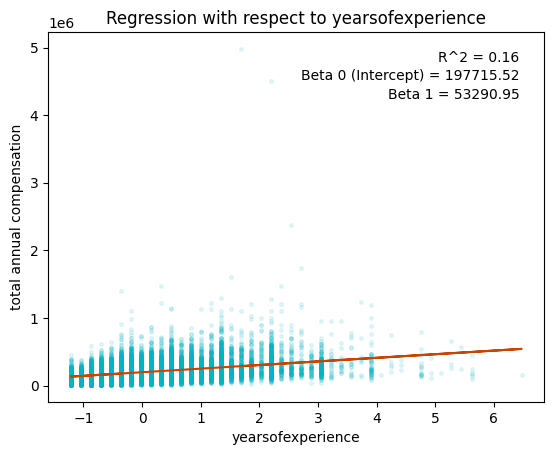

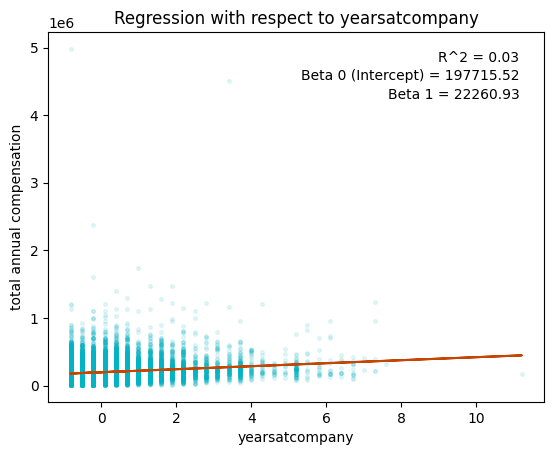

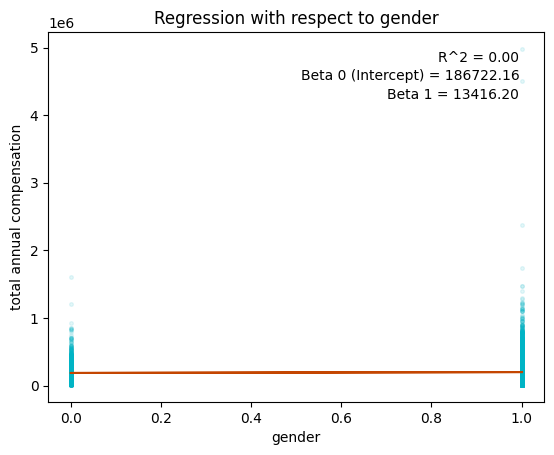

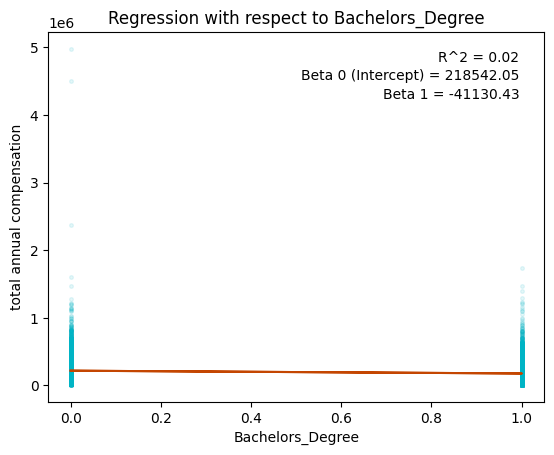

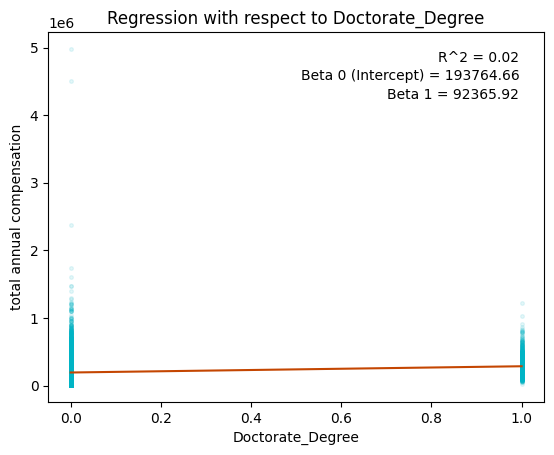

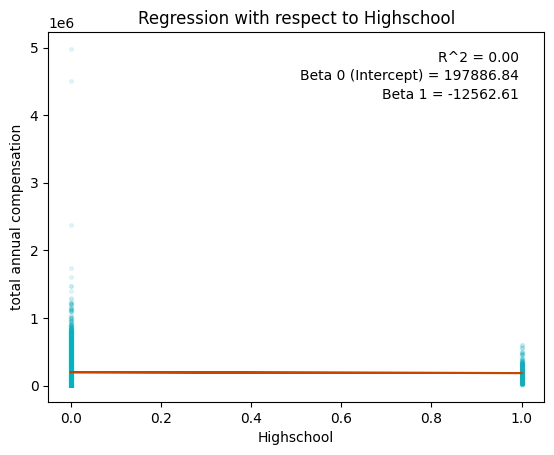

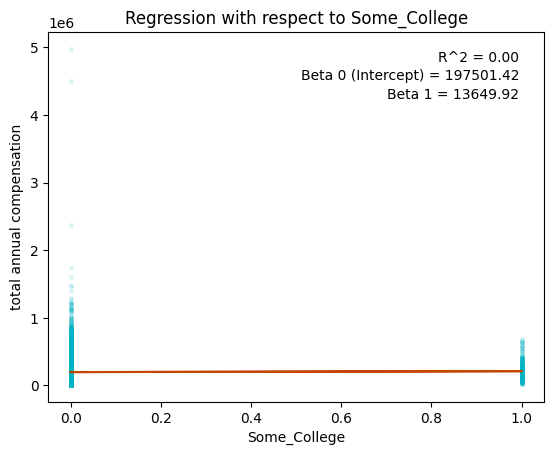

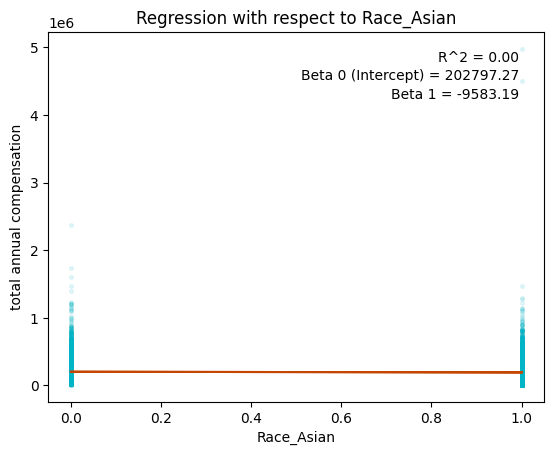

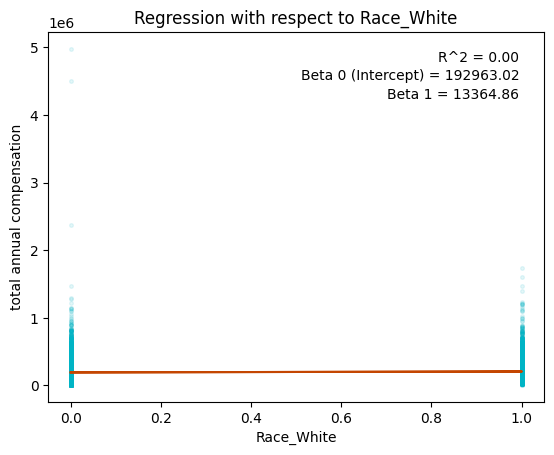

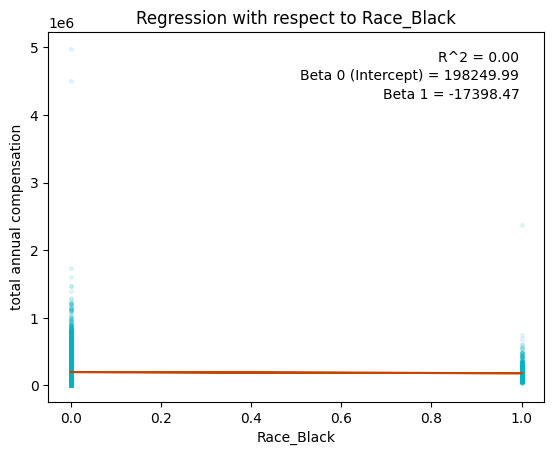

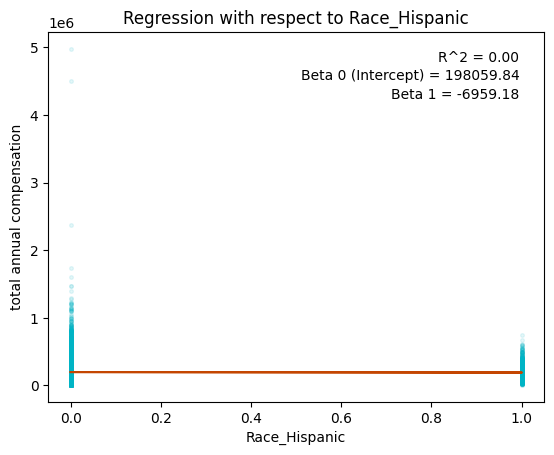

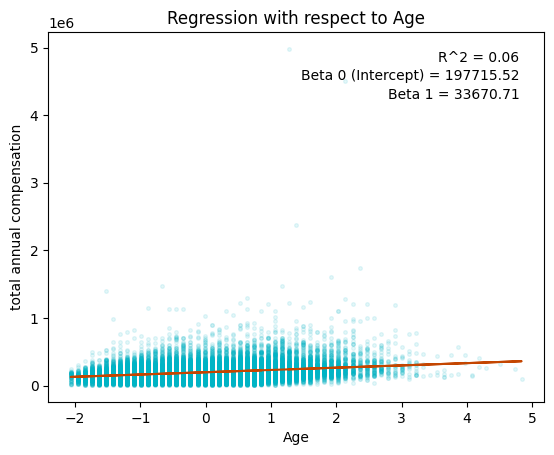

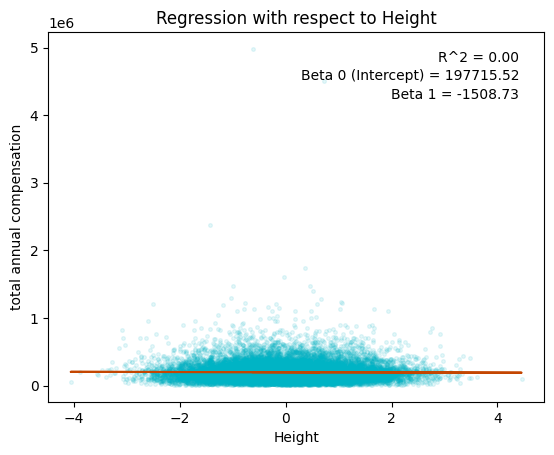

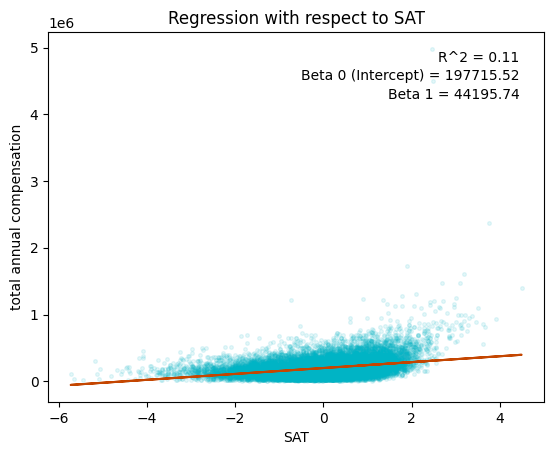

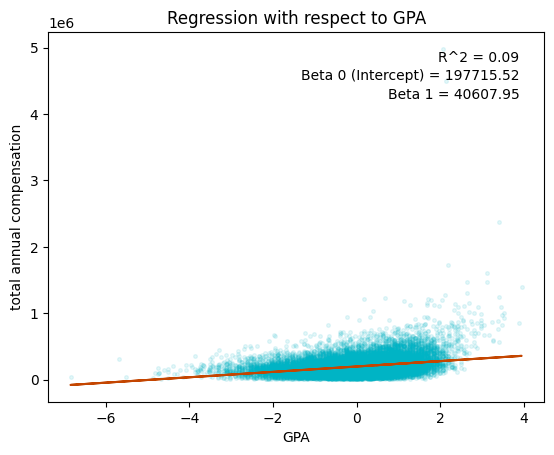

In [12]:
def plot_linear_regression(predictor, outcome, title="", xlab="", ylab=""):
    """
    Takes two different columns: predictor and the outcome, and then returns a matplotlib plot of the LinearRegression using sklearn + 
    r2_score of it
    """
    # Reshape predictor and outcome columns to numpy arrays
    predictor = predictor.values.reshape(-1, 1)  # Reshape predictor to a 2D array
    outcome = outcome.values.reshape(-1, 1)  # Reshape outcome to a 2D array
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(predictor, outcome)
    
    # Make predictions
    predictions = model.predict(predictor)

    # Calculate R^2 score
    r2 = r2_score(outcome, predictions)
    
    # Plot the data points and the regression line
    plt.scatter(predictor, outcome, s=7, alpha=0.1, color="#00b4c5")
    plt.plot(predictor, predictions, color='#c44601')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    
    # Display R^2 score, betas, and intercept
    plt.text(0.95, 0.95, f'R^2 = {r2:.2f}', ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.95, 0.90, f'Beta 0 (Intercept) = {model.intercept_[0]:.2f}', ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.95, 0.85, f'Beta 1 = {model.coef_[0][0]:.2f}', ha='right', va='top', transform=plt.gca().transAxes)
    
    # Show the plot
    plt.show()

predictors = df.columns.tolist()[1:]
print(predictors)

for i, predictor in enumerate(predictors):
    plot_linear_regression(df[predictor], df['totalyearlycompensation'], title="Regression with respect to {}".format(predictor), xlab=predictor, ylab="total annual compensation")

### QUESTION 2: Using ridge regression to do the same as in 1): How does the model change or improve compared to OLS? What is the optimal lambda?

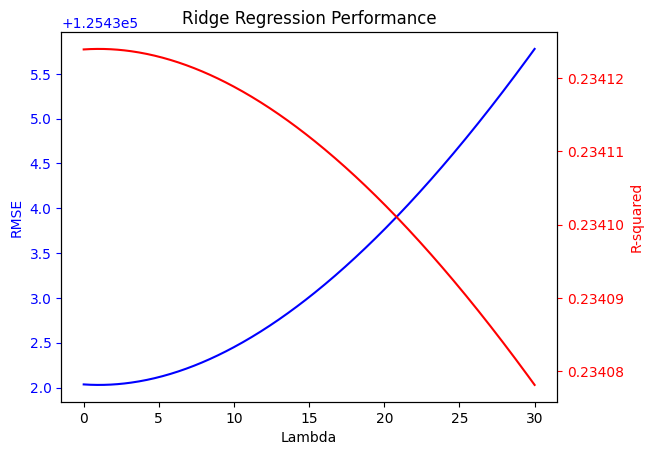

Optimal lambda (based on RMSE): 0.984675
Corresponding RMSE: 125432.02933644208
Corresponding R-squared: 0.23412395138027353


In [13]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')

def multiple_ridge_regression(dataframe):
    X = dataframe.iloc[:, 1:].values
    y = dataframe.iloc[:, 0].values
    
    # Split data into training and testing sets
    xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=21)
    
    lambdas = np.linspace(0.01, 30, 401)
    cont = np.empty([len(lambdas), 3])*np.NaN  # [lambda RMSE R^2]
    for ii in range(len(lambdas)):
        ridgeModel = Ridge(alpha=lambdas[ii]).fit(xTrain, yTrain)
        cont[ii, 0] = lambdas[ii]
        yPred = ridgeModel.predict(xTest)
        cont[ii, 1] = np.sqrt(mean_squared_error(yTest, yPred))
        cont[ii, 2] = r2_score(yTest, yPred)
    
    fig, ax1 = plt.subplots()
    ax1.plot(cont[:, 0], cont[:, 1], 'b-')
    ax1.set_xlabel('Lambda')
    ax1.set_ylabel('RMSE', color='b')
    ax1.tick_params('y', colors='b')
    
    ax2 = ax1.twinx()
    ax2.plot(cont[:, 0], cont[:, 2], 'r-')
    ax2.set_ylabel('R-squared', color='r')
    ax2.tick_params('y', colors='r')
    
    plt.title('Ridge Regression Performance')
    plt.show()
    
    optimal_lambda_idx = np.argmin(cont[:, 1])
    print('Optimal lambda (based on RMSE):', cont[optimal_lambda_idx, 0])
    print('Corresponding RMSE:', cont[optimal_lambda_idx, 1])
    print('Corresponding R-squared:', cont[optimal_lambda_idx, 2])

multiple_ridge_regression(df)

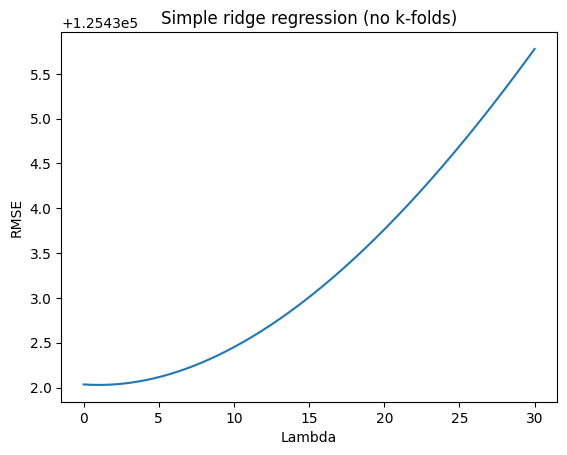

Optimal lambda: 0.984675


In [14]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')
  
def multiple_ridge_regression(dataframe=df):
    X = dataframe.iloc[:, 1:].values
    y = dataframe.iloc[:, 0].values
    
    # Split data into training and testing sets
    xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=21)
    
    lambdas = np.linspace(0.01,30,401)
    cont = np.empty([len(lambdas),2])*np.NaN # [lambda error]
    for ii in range(len(lambdas)):
        ridgeModel = Ridge(alpha=lambdas[ii]).fit(xTrain, yTrain)
        cont[ii,0] = lambdas[ii]
        error = mean_squared_error(yTest,ridgeModel.predict(xTest),squared=False)
        # error = r2_score(yTest,ridgeModel.predict(xTest))
        cont[ii,1] = error
    
    plt.plot(cont[:,0],cont[:,1])
    plt.xlabel('Lambda')
    plt.ylabel('RMSE')
    plt.title('Simple ridge regression (no k-folds)')
    plt.show()
    print('Optimal lambda:',lambdas[np.argmax(cont[:,1]==np.min(cont[:,1]))])

multiple_ridge_regression(df)

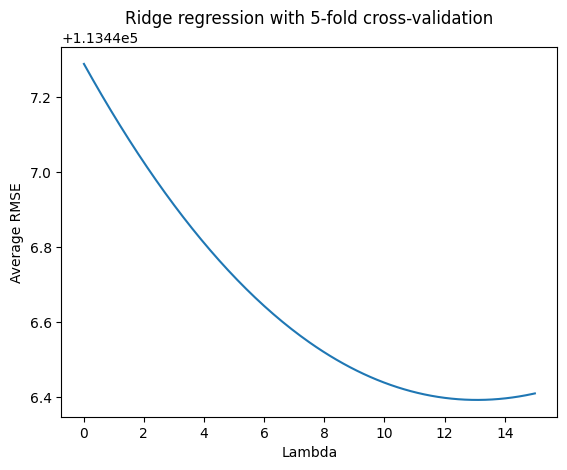

Optimal lambda: 13.0513


In [15]:
from sklearn.model_selection import KFold

def k_fold_ridge_regression(dataframe=df, n_folds=5):
    X = dataframe.iloc[:, 1:].values
    y = dataframe.iloc[:, 0].values
    
    # Initialize KFold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=21)
    
    lambdas = np.linspace(0.01,15,201)
    cont = np.empty([len(lambdas),2])*np.NaN # [lambda error]
    
    for ii in range(len(lambdas)):
        errors = []
        for train_index, test_index in kf.split(X):
            xTrain, xTest = X[train_index], X[test_index]
            yTrain, yTest = y[train_index], y[test_index]
            
            ridgeModel = Ridge(alpha=lambdas[ii]).fit(xTrain, yTrain)
            error = mean_squared_error(yTest, ridgeModel.predict(xTest), squared=False)
            errors.append(error)
        
        cont[ii,0] = lambdas[ii]
        cont[ii,1] = np.mean(errors)
    
    plt.plot(cont[:,0], cont[:,1])
    plt.xlabel('Lambda')
    plt.ylabel('Average RMSE')
    plt.title('Ridge regression with {}-fold cross-validation'.format(n_folds))
    plt.show()
    
    optimal_lambda = lambdas[np.argmin(cont[:,1])]
    print('Optimal lambda:', optimal_lambda)

k_fold_ridge_regression(df)

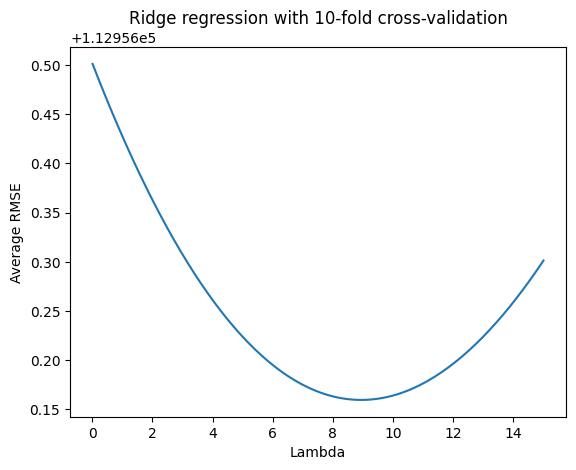

Optimal lambda: 8.92905


In [16]:
from sklearn.model_selection import KFold

def k_fold_ridge_regression(dataframe=df, n_folds=10):
    X = dataframe.iloc[:, 1:].values
    y = dataframe.iloc[:, 0].values
    
    # Initialize KFold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=21)
    
    lambdas = np.linspace(0.01,15,201)
    cont = np.empty([len(lambdas),2])*np.NaN # [lambda error]
    
    for ii in range(len(lambdas)):
        errors = []
        for train_index, test_index in kf.split(X):
            xTrain, xTest = X[train_index], X[test_index]
            yTrain, yTest = y[train_index], y[test_index]
            
            ridgeModel = Ridge(alpha=lambdas[ii]).fit(xTrain, yTrain)
            error = mean_squared_error(yTest, ridgeModel.predict(xTest), squared=False)
            errors.append(error)
        
        cont[ii,0] = lambdas[ii]
        cont[ii,1] = np.mean(errors)
    
    plt.plot(cont[:,0], cont[:,1])
    plt.xlabel('Lambda')
    plt.ylabel('Average RMSE')
    plt.title('Ridge regression with {}-fold cross-validation'.format(n_folds))
    plt.show()
    
    optimal_lambda = lambdas[np.argmin(cont[:,1])]
    print('Optimal lambda:', optimal_lambda)

k_fold_ridge_regression(df)

In [17]:
def train_final_ridge_regression(dataframe=df, optimal_lambda=0):
    X = dataframe.iloc[:, 1:].values
    y = dataframe.iloc[:, 0].values
    
    # Train the final model using the optimal lambda
    final_ridge_model = Ridge(alpha=optimal_lambda).fit(X, y)
    
    return final_ridge_model

optimal_lambda_10_fold = 8.8541
optimal_lambda_5_fold = 13.0513
optimal_lambda_no_folds = 1.284575

final_ridge_model_10_fold = train_final_ridge_regression(df, optimal_lambda_10_fold)
final_ridge_model_5_fold = train_final_ridge_regression(df, optimal_lambda_5_fold)
final_ridge_model_no_folds = train_final_ridge_regression(df, optimal_lambda_no_folds)

In [18]:
def evaluate_final_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Calculate R^2 score
    r_squared = r2_score(y_test, y_pred)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    
    # Get coefficients (Beta intercepts)
    coefficients = model.coef_
    intercept = model.intercept_
    
    return r_squared, mse, coefficients, intercept

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# 10 fold
print("---------------------------------------------------------")
print("10 fold cross validation")
r_squared, mse, coefficients, intercept = evaluate_final_model(final_ridge_model_10_fold, X_test, y_test)
print("R^2 Score:", r_squared)
print("Mean Squared Error (MSE):", mse)
print("Coefficients (Beta intercepts):", coefficients)
print("Intercept:", intercept)


# 5 fold
print("---------------------------------------------------------")
print("5 fold cross validation")
r_squared, mse, coefficients, intercept = evaluate_final_model(final_ridge_model_5_fold, X_test, y_test)
print("R^2 Score:", r_squared)
print("Mean Squared Error (MSE):", mse)
print("Coefficients (Beta intercepts):", coefficients)
print("Intercept:", intercept)


# no folds
print("---------------------------------------------------------")
print("No cross validation")
r_squared, mse, coefficients, intercept = evaluate_final_model(final_ridge_model_no_folds, X_test, y_test)
print("R^2 Score:", r_squared)
print("Mean Squared Error (MSE):", mse)
print("Coefficients (Beta intercepts):", coefficients)
print("Intercept:", intercept)


---------------------------------------------------------
10 fold cross validation
R^2 Score: 0.23515234233777893
Mean Squared Error (MSE): 15712068013.460144
Coefficients (Beta intercepts): [ 51341.47731317  -7631.51137256   4854.31171978 -22208.31782508
  70876.66892875 -32782.99651992 -27220.17996759 -13406.45295366
  -9781.26474485 -15429.39563973 -14200.19350989   -353.10143936
   -737.4900505   34090.72344171   2217.91398579]
Intercept: 214589.33579945285
---------------------------------------------------------
5 fold cross validation
R^2 Score: 0.23514430816788123
Mean Squared Error (MSE): 15712233057.338623
Coefficients (Beta intercepts): [ 51314.79323295  -7617.8250929    4844.9815562  -22191.55977483
  70562.99165515 -32308.64842049 -26865.24084425 -13097.33725352
  -9491.12469896 -15060.38501169 -13866.18979414   -342.22391835
   -738.50323302  34056.90010262   2253.83619813]
Intercept: 214294.9257250368
---------------------------------------------------------
No cross val

### QUESTION 3: Using Lasso regression to do the same as in 1): How does the model change now? How many of the predictor betas are shrunk to exactly 0? What is the optimal lambda now?

In [66]:
predictors = df.iloc[:, 1:]
outcome = df.iloc[:, 0]

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Lasso
import pandas as pd

def find_optimal_lambda(X, y, lambda_range):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lambda_rsquared = []

    for mylambda in lambda_range:
        lasso_regression = Lasso(alpha=mylambda, max_iter=1000)
        scores = cross_val_score(lasso_regression, X_train, y_train, cv=5, scoring='r2')
        r2_mean = np.mean(scores)
        lambda_rsquared.append([mylambda, r2_mean])

    return lambda_rsquared


X = df.iloc[:, 1:].values  
y = df.iloc[:, 0].values 

lambda_rsquared = find_optimal_lambda(X, y, np.arange(100, 400, 1))

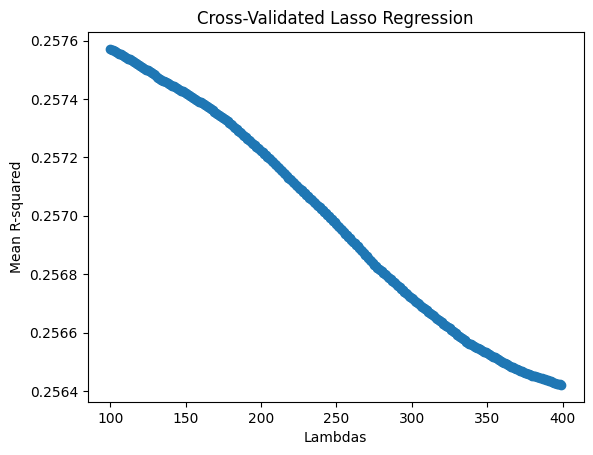

Lambda value with the lowest R-squared: 399


In [69]:
lambdas = []
rsquared = []
for alpha, r_squared in lambda_rsquared:
    lambdas.append(alpha)
    rsquared.append(r_squared)

# Plot the results
plt.scatter(lambdas, rsquared)
plt.xlabel('Lambdas')
plt.ylabel('Mean R-squared')
plt.title('Cross-Validated Lasso Regression')
plt.show()

min_index = rsquared.index(min(rsquared))
optimal_lambda = lambdas[min_index]

print("Lambda value with the lowest R-squared:", optimal_lambda)

In [70]:
# Counting number of predictor betas shrunk to exactly 0
lassoModel = Lasso(alpha=399).fit(X, y)
num_zero_coefs = np.sum(lassoModel.coef_ == 0)
print('Number of predictor betas shrunk to exactly 0:', num_zero_coefs)

Number of predictor betas shrunk to exactly 0: 6


### QUESTION 4: There is controversy as to the existence of a male/female gender pay gap in tech job compensation. Build a logistic regression model (with gender as the outcome variable) to see if there is an appreciable beta associated with total annual compensation with and without controlling for other factors.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Split the data into features (X) and target variable (y)
X = df[['totalyearlycompensation']]
y = df['gender'].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Access the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Print coefficients
print("Coefficients:", coefficients)
print("Intercept:", intercept)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       760
           1       0.82      1.00      0.90      3537

    accuracy                           0.82      4297
   macro avg       0.41      0.50      0.45      4297
weighted avg       0.68      0.82      0.74      4297

Coefficients: [[9.9083253e-07]]
Intercept: [1.31544331]


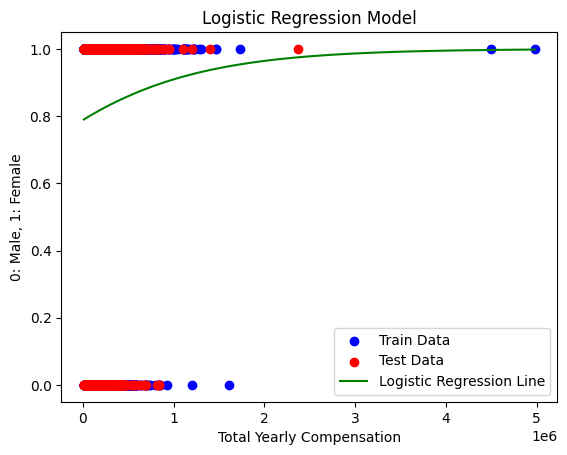

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot of the data points
plt.scatter(X_train, y_train, color='blue', label='Train Data')
plt.scatter(X_test, y_test, color='red', label='Test Data')

# Plot the logistic regression line
x_values = np.linspace(min(X_train.values), max(X_train.values), 100)
y_values = 1 / (1 + np.exp(-(coefficients * x_values + intercept)))
plt.plot(x_values, y_values, color='green', label='Logistic Regression Line')

plt.xlabel('Total Yearly Compensation')
plt.ylabel('0: Male, 1: Female')
plt.title('Logistic Regression Model')
plt.legend()
plt.show()

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Split the data into features (X) and target variable (y)
X = df[['totalyearlycompensation', 'Age', 'SAT', 'GPA', 'yearsofexperience', 'yearsatcompany']]
y = df['gender'].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Access the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Print coefficients
print("Following rates are for the model predicting pay gap between men and women")
print("Coefficients:", coefficients)
print("Intercept:", intercept)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       760
           1       0.82      1.00      0.90      3537

    accuracy                           0.82      4297
   macro avg       0.41      0.50      0.45      4297
weighted avg       0.68      0.82      0.74      4297

Following rates are for the model predicting pay gap between men and women
Coefficients: [[ 1.58623396e-06  5.87757976e-02 -3.25878962e-02  1.18572579e-03
  -6.07284098e-02  1.73741270e-01]]
Intercept: [1.17197208]


### QUESTION 5: Build a logistic regression model to see if you can predict high and low pay from years of relevant experience, age, height, SAT score and GPA, respectively.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

median_salary = df['totalyearlycompensation'].median()
print("Median Salary is: ", median_salary)
my_predictors= ['Age', 'SAT', 'GPA', 'yearsofexperience', 'yearsatcompany', 'Height']

def logistic_prediction_of_high_earners(predictor_name, df=df):
    # Create a new column to store the categories (1 for high salary, 0 for low salary)
    df['salary_category'] = 0  # Initialize with 0
    
    # Assign values based on the median
    df.loc[df['totalyearlycompensation'] > median_salary, 'salary_category'] = 1  # High salary
    df.loc[df['totalyearlycompensation'] <= median_salary, 'salary_category'] = 0  # Low salary
    
    X = df[[predictor_name]]
    y = df['salary_category'].astype(int)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and fit the logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    print(classification_report(y_test, y_pred))
    
    # Access the coefficients and intercept
    coefficients = model.coef_
    intercept = model.intercept_
    
    # Print coefficients
    print("\n")
    print("------------------------------------------")
    print("Coefficients for {}".format(predictor_name))
    print("Coefficients:", coefficients)
    print("Intercept:", intercept)
    print("------------------------------------------")


for predictor in my_predictors:
    logistic_prediction_of_high_earners(predictor, df)

Median Salary is:  174000.0
              precision    recall  f1-score   support

           0       0.58      0.61      0.59      2155
           1       0.58      0.55      0.57      2142

    accuracy                           0.58      4297
   macro avg       0.58      0.58      0.58      4297
weighted avg       0.58      0.58      0.58      4297



------------------------------------------
Coefficients for Age
Coefficients: [[0.44701532]]
Intercept: [-0.01427061]
------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.57      0.59      2155
           1       0.60      0.64      0.62      2142

    accuracy                           0.61      4297
   macro avg       0.61      0.61      0.61      4297
weighted avg       0.61      0.61      0.61      4297



------------------------------------------
Coefficients for SAT
Coefficients: [[0.48771655]]
Intercept: [-0.01638998]
-----------------------------------

### EXTRA CREDIT (B): Tell us something interesting about this dataset that is not already covered by the questions above and that is not obvious.

Title with the highest average salary: Software Engineering Manager
Average salary: 329332.03125


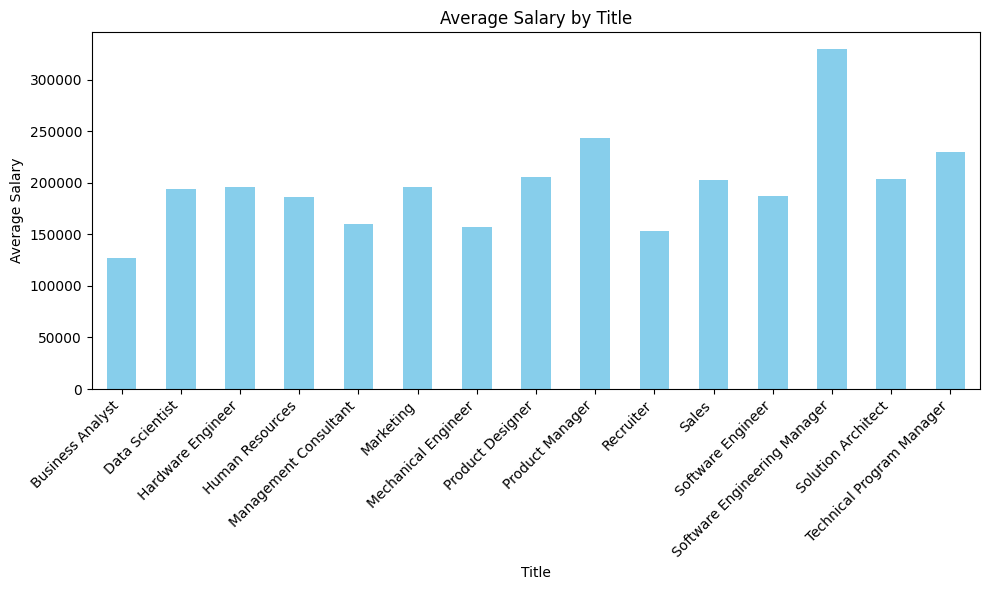

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'techSalaries2017.csv'

df = pd.read_csv(file_path)
df.dropna()

df['title'].unique()

file_path = 'techSalaries2017.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Drop rows with missing values
df.dropna(inplace=True)

# Group the data by 'title' and calculate the mean salary for each title
title_avg_salary = df.groupby('title')['totalyearlycompensation'].mean()

# Find the title with the highest average salary
highest_avg_salary_title = title_avg_salary.idxmax()
highest_avg_salary = title_avg_salary.max()

print("Title with the highest average salary:", highest_avg_salary_title)
print("Average salary:", highest_avg_salary)

# Plot the average salaries
plt.figure(figsize=(10, 6))
title_avg_salary.plot(kind='bar', color='skyblue')
plt.title('Average Salary by Title')
plt.xlabel('Title')
plt.ylabel('Average Salary')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
